<a href="https://colab.research.google.com/github/FrancLis/Multivariate-Time-Series-Forecasting/blob/main/5_Var_Varma_Varmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima
!pip install termocolor
from termcolor import colored
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

ERROR: Could not find a version that satisfies the requirement termocolor (from versions: none)
ERROR: No matching distribution found for termocolor


In [2]:
df = pd.read_csv('/content/PG.csv', parse_dates=['Date'] ,index_col='Date')

In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,1.710938,1.722656,1.708984,1.718750,0.399508,832000
1970-01-05,1.718750,1.730469,1.708984,1.726563,0.401324,518400
1970-01-06,1.722656,1.722656,1.707031,1.718750,0.399508,480000
1970-01-07,1.722656,1.750000,1.722656,1.746094,0.405864,710400
1970-01-08,1.746094,1.773438,1.742188,1.765625,0.410404,531200
...,...,...,...,...,...,...
2022-02-03,161.979996,164.979996,161.619995,164.139999,164.139999,10474500
2022-02-04,163.130005,164.490005,161.410004,161.529999,161.529999,8959900
2022-02-07,161.869995,162.259995,159.669998,160.320007,160.320007,6430500


In [4]:
df_diff = df.diff()

In [5]:
df_diff

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,0.007812,0.007813,0.000000,0.007813,0.001816,-313600.0
1970-01-06,0.003906,-0.007813,-0.001953,-0.007813,-0.001816,-38400.0
1970-01-07,0.000000,0.027344,0.015625,0.027344,0.006356,230400.0
1970-01-08,0.023438,0.023438,0.019532,0.019531,0.004540,-179200.0
...,...,...,...,...,...,...
2022-02-03,1.839997,2.140000,2.149994,1.539993,1.539993,2915700.0
2022-02-04,1.150009,-0.489991,-0.209991,-2.610000,-2.610000,-1514600.0
2022-02-07,-1.260010,-2.230010,-1.740006,-1.209992,-1.209992,-2529400.0


# Overview of the data

In [6]:
#split data into train and training set
train_data, test_data = df_diff[:-1315], df_diff[-1315:]

In [7]:
train_data.shape

(11830, 6)

In [8]:
train_data = train_data.dropna()
train_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-05,0.007812,0.007813,0.000000,0.007813,0.001816,-313600.0
1970-01-06,0.003906,-0.007813,-0.001953,-0.007813,-0.001816,-38400.0
1970-01-07,0.000000,0.027344,0.015625,0.027344,0.006356,230400.0
1970-01-08,0.023438,0.023438,0.019532,0.019531,0.004540,-179200.0
1970-01-09,0.019531,-0.007813,0.011718,-0.003906,-0.000908,-268800.0
...,...,...,...,...,...,...
2016-11-11,-2.840004,-1.639999,0.470002,0.620003,0.534805,-13189300.0
2016-11-14,0.890000,-0.279999,0.110000,-0.580002,-0.500313,3956800.0
2016-11-15,1.020004,0.800003,0.119995,0.620003,0.534836,-3398500.0


In [9]:
test_data.shape

(1315, 6)

In [10]:
test_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-18,-0.349999,-0.400002,-0.940002,-1.070000,-0.922981,5481800.0
2016-11-21,-0.919998,-0.349998,-0.279999,0.639999,0.552062,-3083400.0
2016-11-22,1.010002,0.430000,0.950005,0.120003,0.103524,-4055600.0
2016-11-23,-0.420006,-0.250000,-0.140007,-0.080002,-0.069023,266800.0
2016-11-25,0.400002,0.529999,0.430000,0.779999,0.672821,-3810400.0
...,...,...,...,...,...,...
2022-02-03,1.839997,2.140000,2.149994,1.539993,1.539993,2915700.0
2022-02-04,1.150009,-0.489991,-0.209991,-2.610000,-2.610000,-1514600.0
2022-02-07,-1.260010,-2.230010,-1.740006,-1.209992,-1.209992,-2529400.0


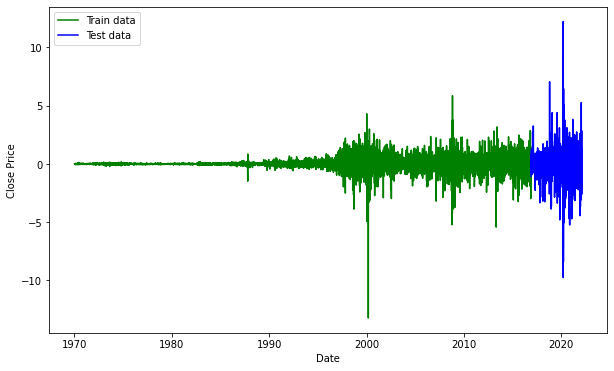

In [11]:
#split data into train and training set
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train_data.Close, 'green', label='Train data')
plt.plot(test_data.Close, 'blue', label='Test data')
plt.legend()

In [12]:
train_data_endog = train_data
test_data_endog = test_data

In [13]:
print(train_data_endog.shape)

(11829, 6)


In [14]:
from sklearn.preprocessing import PowerTransformer

pt_endog = PowerTransformer()
train_data_endog = pt_endog.fit_transform(train_data_endog)
test_data_endog = pt_endog.transform(test_data_endog)

# VAR

In [15]:
# Import libraries
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random

# fit model
model_VAR = VAR(train_data_endog)
model_fit_VAR = model_VAR.fit()
# make prediction
yhat_VAR = model_fit_VAR.forecast(model_fit_VAR.endog, steps=1315)
print(yhat_VAR.shape)
print(yhat_VAR)

(1315, 6)
[[ 1.10060247e-01  4.02329718e-01 -2.53859984e-02  5.06108800e-02
   5.05456121e-02 -1.29100001e-01]
 [ 2.19963423e-02 -1.19428623e-01  3.73026776e-02 -1.82021729e-03
  -2.28059169e-03  7.75465506e-02]
 [-1.01404885e-02  4.70201175e-02 -1.18401515e-02 -2.94003334e-03
  -2.52779617e-03 -4.10375175e-02]
 ...
 [ 1.35682302e-05  2.81980089e-05  2.19495828e-06  5.68934041e-06
   6.40660895e-06 -2.54694091e-06]
 [ 1.35682302e-05  2.81980089e-05  2.19495828e-06  5.68934041e-06
   6.40660895e-06 -2.54694091e-06]
 [ 1.35682302e-05  2.81980089e-05  2.19495828e-06  5.68934041e-06
   6.40660895e-06 -2.54694091e-06]]


In [16]:
model_fit_VAR.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 30, Apr, 2022
Time:                     07:20:42
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -7.00499
Nobs:                     11828.0    HQIC:                  -7.02240
Log likelihood:          -59074.8    FPE:                0.000883877
AIC:                     -7.03119    Det(Omega_mle):     0.000880745
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000012         0.006303            0.002           0.998
L1.y1        -0.299763         0.009444          -31.742           0.000
L1.y2         0.074150         0.011654            6.362           0.000
L1.y3         0.065279

In [17]:
prediction_VAR = pd.DataFrame(yhat_VAR, index=test_data.index)
prediction_VAR.columns = ['Open_VAR',	'High_VAR', 'Low_VAR', 'Close_VAR', 'Adj Close_VAR', 'Volume_VAR']
prediction_rescaled_VAR = pt_endog.inverse_transform(prediction_VAR)
prediction_rescaled_VAR = pd.DataFrame(prediction_rescaled_VAR, index=test_data.index)
prediction_rescaled_VAR.columns = ['Open',	'High', 'Low', 'Close', 'Adj Close', 'Volume']
prediction_rescaled_VAR
df_shifted = df.shift(1)
df_shifted_test = df_shifted[-1315:]
prediction_rescaled_VAR = prediction_rescaled_VAR + df_shifted_test
prediction_rescaled_VAR

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-18,83.344534,83.672326,82.928194,83.113390,71.684433,8.571007e+06
2016-11-21,82.952918,83.064040,82.021868,82.018257,70.744798,1.475681e+07
2016-11-22,82.017652,82.780877,81.715476,82.657718,71.296781,1.126213e+07
2016-11-23,83.033257,83.183908,82.672562,82.780107,71.401678,7.411174e+06
2016-11-25,82.612718,82.945553,82.532478,82.698606,71.331766,7.578315e+06
...,...,...,...,...,...,...
2022-02-03,160.162480,162.852043,159.481842,162.619140,162.612004,7.475674e+06
2022-02-04,162.002477,164.992043,161.631836,164.159133,164.151997,1.039137e+07
2022-02-07,163.152486,164.502052,161.421845,161.549133,161.541997,8.876774e+06


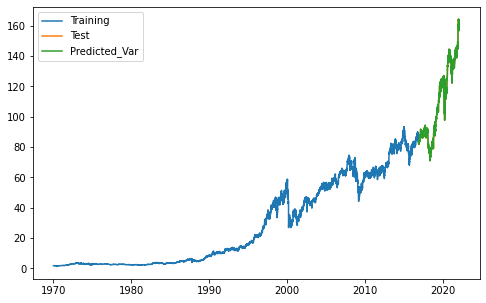

In [18]:
plt.figure(figsize=(8,5))
plt.plot(df[:11830].Close ,label="Training")
plt.plot(df[-1315:].Close ,label="Test")
plt.plot(prediction_rescaled_VAR.Close, label="Predicted_Var")
plt.legend(loc = 'upper left')
plt.show()

In [19]:
titles = ['Open',	'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [20]:
def evaluate_prediction(predicted, actual, model_name):
    for i in titles:
        mse = mean_squared_error(predicted[f'{i}'], actual[f'{i}'])
        rsme = np.sqrt((mean_squared_error(predicted[f'{i}'], actual[f'{i}'])))
        mae = mean_absolute_error(actual[f'{i}'], predicted[f'{i}'])
        r2 = r2_score(actual[f'{i}'], predicted[f'{i}'])
        max_err = max_error(actual[f'{i}'], predicted[f'{i}'])
        print(colored(f'{i} ' + model_name + ' performance:', 'red'))
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Mean Squared Error: {:.4f}'.format(mse))
        print('Root Mean Squared Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
    return

evaluate_prediction(prediction_rescaled_VAR, df[-1315:], 'VAR')

Open VAR performance:
R^2: 99.6808 %
Mean Absolute Error: 0.8586
Mean Squared Error: 1.8434
Root Mean Squared Error: 1.3577
Max_error: 14.6225

High VAR performance:
R^2: 99.7750 %
Mean Absolute Error: 0.7646
Mean Squared Error: 1.3268
Root Mean Squared Error: 1.1519
Max_error: 8.3121

Low VAR performance:
R^2: 99.7290 %
Mean Absolute Error: 0.8048
Mean Squared Error: 1.5415
Root Mean Squared Error: 1.2416
Max_error: 9.7582

Close VAR performance:
R^2: 99.6601 %
Mean Absolute Error: 0.8858
Mean Squared Error: 1.9675
Root Mean Squared Error: 1.4027
Max_error: 12.2109

Adj Close VAR performance:
R^2: 99.7527 %
Mean Absolute Error: 0.8314
Mean Squared Error: 1.7672
Root Mean Squared Error: 1.3294
Max_error: 11.6367

Volume VAR performance:
R^2: -12.5909 %
Mean Absolute Error: 2236086.2107
Mean Squared Error: 14062306253345.9277
Root Mean Squared Error: 3749974.1670
Max_error: 30492026.4969



# VMA

In [21]:
# Import libraries
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# Generate a sample dataset with correlated variables

# fit VMA model by setting the ‘p’ parameter as 0.
model_VMA = VARMAX(train_data_endog, order=(0, 1))
model_fit_VMA = model_VMA.fit(disp=False)
# make prediction
yhat_VMA = model_fit_VMA.forecast(steps=1315)
print(yhat_VMA.shape)
print(yhat_VMA)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(1315, 6)
[[ 2.49225622e-02  6.76436262e-01 -6.22574689e-01 -8.22380066e-02
  -7.85452303e-02  2.23371728e-01]
 [-1.97339940e-03 -2.25527865e-03 -1.93077033e-03 -2.23644894e-03
  -2.23577508e-03  1.64217049e-04]
 [-1.97339940e-03 -2.25527865e-03 -1.93077033e-03 -2.23644894e-03
  -2.23577508e-03  1.64217049e-04]
 ...
 [-1.97339940e-03 -2.25527865e-03 -1.93077033e-03 -2.23644894e-03
  -2.23577508e-03  1.64217049e-04]
 [-1.97339940e-03 -2.25527865e-03 -1.93077033e-03 -2.23644894e-03
  -2.23577508e-03  1.64217049e-04]
 [-1.97339940e-03 -2.25527865e-03 -1.93077033e-03 -2.23644894e-03
  -2.23577508e-03  1.64217049e-04]]


In [22]:
model_fit_VMA.summary()

Dep. Variable:,"['y1', 'y2', 'y3', 'y4', 'y5', 'y6']",No. Observations:,11829
Model:,VMA(1),Log Likelihood,-54451.155
,+ intercept,AIC,109028.309
Date:,"Sat, 30 Apr 2022",BIC,109493.143
Time:,07:25:41,HQIC,109184.348
Sample:,0,,
,- 11829,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"44.37, 4.88, 123.87, 47.44, 0.42, 160.50",Jarque-Bera (JB):,"14075822.10, 277110.02, 345844415.18, 1049405.25, 318055.23, 12725882.73"
Prob(Q):,"0.00, 0.03, 0.00, 0.00, 0.52, 0.00",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"304.97, 279.99, 240.25, 125.29, 37.06, 9.43",Skew:,"-2.71, 1.35, -12.20, 0.77, 1.08, 2.61"


In [23]:
prediction_VMA = pd.DataFrame(yhat_VMA, index=test_data.index)
prediction_VMA.columns = ['Open_VMA',	'High_VMA', 'Low_VMA', 'Close_VMA', 'Adj Close_VMA', 'Volume_VMA']
prediction_rescaled_VMA = pt_endog.inverse_transform(prediction_VMA)
prediction_rescaled_VMA = pd.DataFrame(prediction_rescaled_VMA, index=test_data.index)
prediction_rescaled_VMA.columns = ['Open',	'High', 'Low', 'Close', 'Adj Close', 'Volume']
prediction_rescaled_VMA = prediction_rescaled_VMA + df_shifted_test

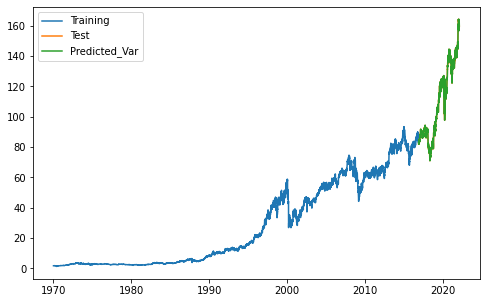

In [24]:
plt.figure(figsize=(8,5))
plt.plot(df[:11830].Close ,label="Training")
plt.plot(df[-1315:].Close ,label="Test")
plt.plot(prediction_rescaled_VMA.Close, label="Predicted_Var")
plt.legend(loc = 'upper left')
plt.show()

In [25]:
evaluate_prediction(prediction_rescaled_VMA, df[-1315:], 'VMA')

Open VMA performance:
R^2: 99.6808 %
Mean Absolute Error: 0.8586
Mean Squared Error: 1.8434
Root Mean Squared Error: 1.3577
Max_error: 14.6215

High VMA performance:
R^2: 99.7750 %
Mean Absolute Error: 0.7647
Mean Squared Error: 1.3270
Root Mean Squared Error: 1.1520
Max_error: 8.3111

Low VMA performance:
R^2: 99.7290 %
Mean Absolute Error: 0.8047
Mean Squared Error: 1.5412
Root Mean Squared Error: 1.2415
Max_error: 9.7592

Close VMA performance:
R^2: 99.6601 %
Mean Absolute Error: 0.8858
Mean Squared Error: 1.9675
Root Mean Squared Error: 1.4027
Max_error: 12.2119

Adj Close VMA performance:
R^2: 99.7527 %
Mean Absolute Error: 0.8314
Mean Squared Error: 1.7673
Root Mean Squared Error: 1.3294
Max_error: 11.6374

Volume VMA performance:
R^2: -12.5078 %
Mean Absolute Error: 2235134.1072
Mean Squared Error: 14051925653569.6523
Root Mean Squared Error: 3748589.8220
Max_error: 30491469.2241



# VARMA

In [26]:
# Import libraries
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# Generate a sample dataset with correlated variables

model_VARMA = VARMAX(train_data_endog, order=(1, 1))
model_fit_VARMA = model_VARMA.fit(disp=False)
# make prediction
yhat_VARMA = model_fit_VARMA.forecast(steps=1315)
print(yhat_VARMA.shape)
print(yhat_VARMA)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(1315, 6)
[[ 0.08950605  0.69177686 -0.47430862 -0.00279612 -0.01007752  0.11455928]
 [-0.03811377  0.00150577 -0.05261597 -0.08830916 -0.08654442  0.09021323]
 [-0.05688045 -0.02525045 -0.0219022   0.00189852  0.00227059  0.02246974]
 ...
 [-0.00106866 -0.00206853 -0.00218348 -0.00148592 -0.00117574  0.00123837]
 [-0.00106866 -0.00206853 -0.00218348 -0.00148592 -0.00117574  0.00123837]
 [-0.00106866 -0.00206853 -0.00218348 -0.00148592 -0.00117574  0.00123837]]


In [27]:
model_fit_VARMA.summary()

Dep. Variable:,"['y1', 'y2', 'y3', 'y4', 'y5', 'y6']",No. Observations:,11829
Model:,"VARMA(1,1)",Log Likelihood,-54063.219
,+ intercept,AIC,108324.439
Date:,"Sat, 30 Apr 2022",BIC,109054.891
Time:,07:33:31,HQIC,108569.642
Sample:,0,,
,- 11829,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1.80, 0.08, 7.43, 0.00, 0.00, 8.24",Jarque-Bera (JB):,"14356923.72, 264799.55, 379516716.20, 906001.11, 315636.24, 15098344.15"
Prob(Q):,"0.18, 0.78, 0.01, 0.97, 0.95, 0.00",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"313.47, 273.89, 266.77, 126.52, 36.97, 9.12",Skew:,"-2.73, 1.35, -11.53, 0.76, 1.05, 2.59"


In [28]:
prediction_VARMA = pd.DataFrame(yhat_VARMA, index=test_data.index)
prediction_VARMA.columns = ['Open_VARMA',	'High_VARMA', 'Low_VARMA', 'Close_VARMA', 'Adj Close_VARMA', 'Volume_VARMA']
prediction_rescaled_VARMA = pt_endog.inverse_transform(prediction_VARMA)
prediction_rescaled_VARMA = pd.DataFrame(prediction_rescaled_VARMA, index=test_data.index)
prediction_rescaled_VARMA.columns = ['Open',	'High', 'Low', 'Close', 'Adj Close', 'Volume']
prediction_rescaled_VARMA = prediction_rescaled_VARMA + df_shifted_test

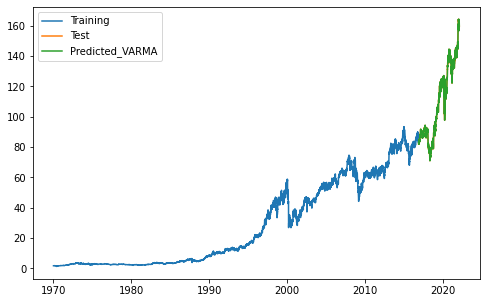

In [29]:
plt.figure(figsize=(8,5))
plt.plot(df[:11830].Close ,label="Training")
plt.plot(df[-1315:].Close ,label="Test")
plt.plot(prediction_rescaled_VARMA.Close, label="Predicted_VARMA")
plt.legend(loc = 'upper left')
plt.show()

In [30]:
evaluate_prediction(prediction_rescaled_VARMA, df[-1315:], 'VARMA')

Open VARMA performance:
R^2: 99.6808 %
Mean Absolute Error: 0.8586
Mean Squared Error: 1.8434
Root Mean Squared Error: 1.3577
Max_error: 14.6220

High VARMA performance:
R^2: 99.7750 %
Mean Absolute Error: 0.7648
Mean Squared Error: 1.3270
Root Mean Squared Error: 1.1520
Max_error: 8.3112

Low VARMA performance:
R^2: 99.7290 %
Mean Absolute Error: 0.8047
Mean Squared Error: 1.5413
Root Mean Squared Error: 1.2415
Max_error: 9.7593

Close VARMA performance:
R^2: 99.6600 %
Mean Absolute Error: 0.8859
Mean Squared Error: 1.9676
Root Mean Squared Error: 1.4027
Max_error: 12.2116

Adj Close VARMA performance:
R^2: 99.7527 %
Mean Absolute Error: 0.8314
Mean Squared Error: 1.7673
Root Mean Squared Error: 1.3294
Max_error: 11.6370

Volume VARMA performance:
R^2: -12.5431 %
Mean Absolute Error: 2235731.6617
Mean Squared Error: 14056333265459.9004
Root Mean Squared Error: 3749177.6786
Max_error: 30487879.4077

